In [1]:
from pathlib import Path
from klimaatbestendige_netwerken.pyBIVAS_plot import pyBIVAS_plot as pyBIVAS
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import json

In [211]:
outputdir = Path('preprocessing_extended')
outputdir.mkdir(exist_ok=True)

# From De Jong (2020). Digital Twin Waterways: Water levels and water depths on the river Rhine. Deltares memo 11205224-000-ZWS-0011, v1.0 d.d. 12 august 2020
additional_depth_functions = {
	'Kaub': lambda Q: 12.20 * Q**0.08 - 21.02 + -1.12,
	'Ruhrort': lambda Q: 0.07**0.58 - 1.47 + -0.47,
	'Emmerich': lambda Q: 0.10**0.53 - 3.28 + -1.96
}



In [2]:
outputdir = Path('preprocessing_15p')
outputdir.mkdir(exist_ok=True)

knelpunt_arcs = {
        # LOBITH?
    'WA_Nijmegen': 6321,
    'WA_Ewijk': 7046,
    'WA_Ophemert': 8871,
    'WA_St. Andries': 7362,
    'WA_Zaltbommel': 7265,
    'NRL_Arnhem': 6621,
    'BR_Duitsland': 21116,
    'MWK_Weurt': 6317,
    'MA_Niftrik': 7391,
    'IJ_Velp': 6510,
    'IJ_Brummen': 5916,
    'IJ_Wilp': 5699,
    'IJ_Terwolde': 5476,
    'IJ_Wapenveld': 4567,
    'IJ_Zalk': 3855
}
knelpunt_arcs_array = list(knelpunt_arcs.values())

In [3]:
# outputdir = Path('preprocessing_4p')
# outputdir.mkdir(exist_ok=True)

# knelpunt_arcs = {
#     'WA_Nijmegen': 6321,
# #     'WA_Ewijk': 7046,
# #     'WA_Ophemert': 8771,
#     'WA_St. Andries': 7362,
# #     'WA_Zaltbommel': 7265,
# #     'NRL_Arnhem': 6621,
#     'BR_Duitsland': 21116,
# #     'MWK_Weurt': 6317,
# #     'MA_Niftrik': 7391,
#     'IJ_Velp': 6510,
# #     'IJ_Brummen': 5916,
# #     'IJ_Wilp': 5699,
# #     'IJ_Terwolde': 5476,
# #     'IJ_Wapenveld': 4567,
# #     'IJ_Zalk': 3855
# }
# knelpunt_arcs_array = list(knelpunt_arcs.values())

In [ ]:
outputdir = Path('preprocessing_KBN_v0.1')
outputdir.mkdir(exist_ok=True)

knelpunt_arcs = {
        # LOBITH?, Erlecom, DL x3, Ma, 
    'WA_Nijmegen': 6321,
    'WA_Ewijk': 7046,
    'WA_Ophemert': 8871,
    'WA_St. Andries': 7362,
    'WA_Zaltbommel': 7265,
    'NRL_Arnhem': 6621,
    'BR_Duitsland': 21116,
    'MWK_Weurt': 6317,
    'MA_Niftrik': 7391,
    'IJ_Velp': 6510,
    'IJ_Brummen': 5916,
    'IJ_Wilp': 5699,
    'IJ_Terwolde': 5476,
    'IJ_Wapenveld': 4567,
    'IJ_Zalk': 3855
}
knelpunt_arcs_array = list(knelpunt_arcs.values())

In [4]:
BIVAS_results_folder = Path(r'n:\Projects\11203500\11203738\B. Measurements and calculations\WP5 Hoofdvaarwegennet\Scheepvaartmodellering\BIVAS_results')

B = pyBIVAS(BIVAS_results_folder / 'Bivas_Run3 Q Q1800 T Ref_2014.db')
B.set_scenario(52)

In [5]:
B.network_arcs(outputfileshape=outputdir / 'arcs.json');

In [6]:
# Export locations
knelpunt_to_shape = B.arcs.loc[knelpunt_arcs_array][['geometry']]
knelpunt_to_shape['name'] = knelpunt_arcs.keys()
knelpunt_to_shape['geometry'] = knelpunt_to_shape['geometry'].centroid

knelpunt_to_shape.reset_index().to_file(outputdir / 'arcs_knelpunten.json', driver='GeoJSON')

In [7]:
# get results for all trips
trips = B.routestatistics_advanced(group_by=['TripsID'])
trips.to_json(outputdir / 'trips.json')

In [8]:
# Get for each trip which knelpunten are passed (this takes approx. 1 hour to compute)
knelpunt_route = {}
for t_id in tqdm(trips.index):
    route_arcs = B.route_arcs(t_id)
    
    knelpunt_route[t_id] = np.isin(knelpunt_arcs_array, route_arcs.ArcID.to_list())
    
knelpunt_route = pd.DataFrame(knelpunt_route).T
knelpunt_route.columns = knelpunt_arcs.keys()

100%|█████████████████████████████████████████████████████████████████████████| 387684/387684 [42:12<00:00, 153.09it/s]


In [24]:
# temp = knelpunt_route.copy()
# temp[1] = 1
# count_combinations = temp.groupby(knelpunt_route.columns.to_list(), axis=0)[1].count()
# count_combinations

In [28]:
# # Number of possible combinations
# total_number_combinations = 2 ** (len(knelpunt_arcs))
# total_number_combinations

# from itertools import chain, combinations

# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)
#     return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# # all possible combinations
# all_combinations = list(powerset(list(knelpunt_arcs.keys())))
# len(all_combinations)

In [11]:
# Get dictionary of trip_ids per unique route 

# Get for each combination of columns the indices with this combination
i_per_group = knelpunt_route.groupby(knelpunt_route.columns.to_list(), axis=0).indices

# Rename index from boolean to set of knelpunten
# Rename values from index to trip_id
i_per_group = {frozenset(knelpunt_route.columns[list(i)]): knelpunt_route.index[indices]  for i, indices in i_per_group.items()}

# Write to json, this file is not really used later on (first convert, than write)
with open(outputdir / 'route_tripid.json', 'w') as fout:
    simple_dict = {",".join(list(k)): list([int(l) for l in v]) for k, v in i_per_group.items()}
    json.dump(simple_dict, fout, indent=2)

# Show the results
# pd.Series({k: len(v) for k, v in i_per_group.items()}).sort_values()

In [12]:
# Read QH per knelpunt
waterscenario_folder = Path(r'n:\Projects\11203500\11203738\B. Measurements and calculations\WP5 Hoofdvaarwegennet\Scheepvaartmodellering\Waterscenario\create_rerun_after_report')

QH = {}
QQ = {}

for Q in [700, 850, 1020, 1400, 1800]:
    data = pd.read_csv(waterscenario_folder / f'waterscenario_15_Q{Q}.csv')
    data = data.set_index('ArcID').reindex(knelpunt_arcs_array)
    QH[Q] = data['WaterDepth__m']
    QQ[Q] = data['RateOfFlow__m3_s']
    
QH = pd.concat(QH, axis=1)
QH = QH.fillna(9)
QH.index = knelpunt_arcs.keys()

# QH.to_json(outputdir / 'knelpunt_discharge_waterdepth.json', orient='index', indent=2)

QQ = pd.concat(QQ, axis=1)
QQ.index = knelpunt_arcs.keys()

# Fill nans with Lobith values
QQ = QQ.fillna({Q:Q for Q in QQ.columns})

# QQ.to_json(outputdir / 'knelpunt_discharge_waterdepth.json', orient='index', indent=2)

# Manual create json
QH_json = {}
for k in QH.index:
    QH_json[k] = {np.round(Q, 0): np.round(H, 3) for Q, H in zip(QQ.loc[k].values, QH.loc[k].values)}

outputfile = outputdir / 'knelpunt_discharge_waterdepth.json'
with open(outputfile, 'w') as fout:
    fout.write(json.dumps(QH_json, indent=2))
# Test read function
# pd.read_json(outputdir / 'knelpunt_discharge_waterdepth.json')

In [13]:
# VD-EUR per corridor

def costs(trips, depth):
    """
    Compute costs (and more) for list of trips if the depth is lower than :
    
      trips: output from pyBIVAS (routestatistics_advanced(group_by=['TripsID'])) or a subset of this data [DataFrame]
      depth: given depth [float]
    
    returns: [float]
      effect: number of trips affected by limiting water depth
      effect: loss in tonnage due to limiting water depth
      effect: loss in potential tonnage due to limiting water depth (the tonnage at LoadCapacity)
      reaction: increase in number of trips due to limiting water depth
      reaction: increase in sailing costs due to limiting water depth
    
    """
    # Decrease in load (0 to 100%)
    load_decrease = 1 - ((trips['Depth__m'] - depth) * 100 * trips['TPCMI']) / trips['Totale Vracht (ton)']
    load_decrease.clip(lower=0, upper=1, inplace=True)  # Maximum realistic limits
    load_decrease.fillna(0, inplace=True)  # For empty vessels 

    # Effect: decrease in tonnage
    tonnage = load_decrease.clip(lower=0, upper=1) * trips_subset['Totale Vracht (ton)']
    
    # Effect: (does not work for empty ships!)
#     tonnage_potential = (load_decrease.clip(lower=0) * trips['Beladingsgraad']).clip(upper=1) * trips['LoadCapacity__t']
    
    beladingsgraad_potential = ((depth - trips['Ledige_diepgang']) / (trips['Maximale_diepgang'] - trips['Ledige_diepgang']))
    beladingsgraad_potential.clip(lower=0, upper=1, inplace=True)
    beladingsgraad_potential.fillna(0, inplace=True)  # Nans exist because of vessel with loadcapacity=0
    tonnage_potential = beladingsgraad_potential * trips['LoadCapacity__t']

    # Reaction: Minimal of 0.2 (so max 80% reduction), maximum of 1.0 (no change)
    load_decrease.clip(lower=0.2, upper=1, inplace=True)
    trips_increase = load_decrease ** -1
    
    # Reaction: increase in (variable) costs and number of trips
    costs_n = trips['Totale Vaste Vaarkosten (EUR)'] + trips['Totale Variabele Vaarkosten (EUR)'] * trips_increase
    trips_n = trips['Aantal Vaarbewegingen (-)'] * trips_increase  # This is only necessary if in the original data the trips != 1
    
    response = pd.DataFrame(
        index = trips.index,
        data = {
            'trips affected': ((trips['Depth__m'] > depth) * trips['Aantal Vaarbewegingen (-)']),
            'tonnage' : tonnage,
            'tonnage potential' : tonnage_potential,
            'costs' : costs_n,
            'trips' : trips_n,
        }
    )
    
#     response_total = response.sum()
    return response

In [14]:
# For each route, get effect of a lowering waterdepth based on all ships passing on this (unique) route
all_depths = np.linspace(0, 10, 101)
all_depths = np.round(all_depths, 2)

effect_and_reaction = {}

for ks, tripids in tqdm(i_per_group.items()):
    
    # Get all trips on route in the full year
    trips_subset = trips.reindex(tripids)
    
    # Compute effect on tonnage and reaction in trips and costs
    effect_and_reaction[ks] = pd.DataFrame(
        data=[costs(trips_subset,  depth).sum() for depth in all_depths], 
        index=all_depths,
    )
    
effect_and_reaction = pd.concat(effect_and_reaction, axis=1).T.swaplevel(axis=0)

# Convert to per day
effect_and_reaction = effect_and_reaction / 365

# Export totalcosts for use in model
totalcosts = effect_and_reaction.loc['costs']
totalcosts.reset_index().rename(columns={'index': 'routes'}).to_json(outputdir / 'route_depth_costs.json', double_precision=2)

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:56<00:00,  1.85it/s]


In [15]:
# For each route, get effect of a lowering waterdepth based on all ships passing on this (unique) route
all_depths = np.linspace(0, 10, 101)
all_depths = np.round(all_depths, 2)

effect_and_reaction_subgroups = {}
groups = ['Origin_Zone', 'Destination_Zone', 'Vorm']

for ks, tripids in i_per_group.items():
    
    # Get all trips on route in the full year
    trips_subset = trips.reindex(tripids)
    
    groupby_subset = trips_subset.groupby(groups)

    # Compute effect on tonnage and reaction in trips and costs
    route_effect_and_reaction = {}
    for depth in tqdm(all_depths):
        response = costs(trips_subset,  depth)

        response_grouped = {}
        for k, i in groupby_subset.indices.items():
            id = trips_subset.index[i]
            response_grouped[k] = response.reindex(id, axis=0).sum()
        response_grouped = pd.concat(response_grouped, axis=0)
        route_effect_and_reaction[depth] = response_grouped
    route_effect_and_reaction = pd.concat(route_effect_and_reaction, axis=0).unstack(level=0).T
    
    effect_and_reaction_subgroups[ks] = route_effect_and_reaction

effect_and_reaction_subgroups = pd.concat(effect_and_reaction_subgroups, axis=1)

# Convert to per day
effect_and_reaction_subgroups = effect_and_reaction_subgroups / 365

# Export totalcosts for use in model
totalcosts_subgroups = effect_and_reaction_subgroups.xs('costs', axis=1, level=-1)
totalcosts_subgroups.reset_index().rename(columns={'index': 'routes'}).to_json(outputdir / 'route_depth_costs_subgroups.json', double_precision=2)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:02<00:00, 39.00it/s]


# Some postprocessing and plots

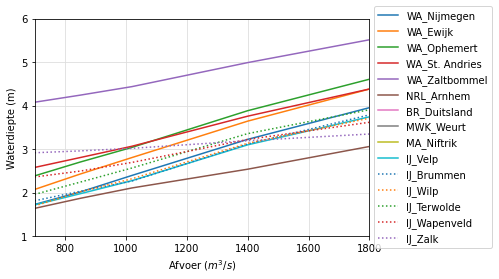

In [209]:
# Plot QH
styles = ['-'] * 10 +  [':'] * 10 
QH.T.plot(style=styles)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(c='#DDD')
plt.autoscale('x', tight=True)
plt.ylim(1, 6)
plt.xlabel('Afvoer ($m^3/s$)')
plt.ylabel('Waterdiepte (m)')
plt.savefig(outputdir / 'knelpunt_discharge_waterdepth.png', dpi=300, bbox_inches='tight')

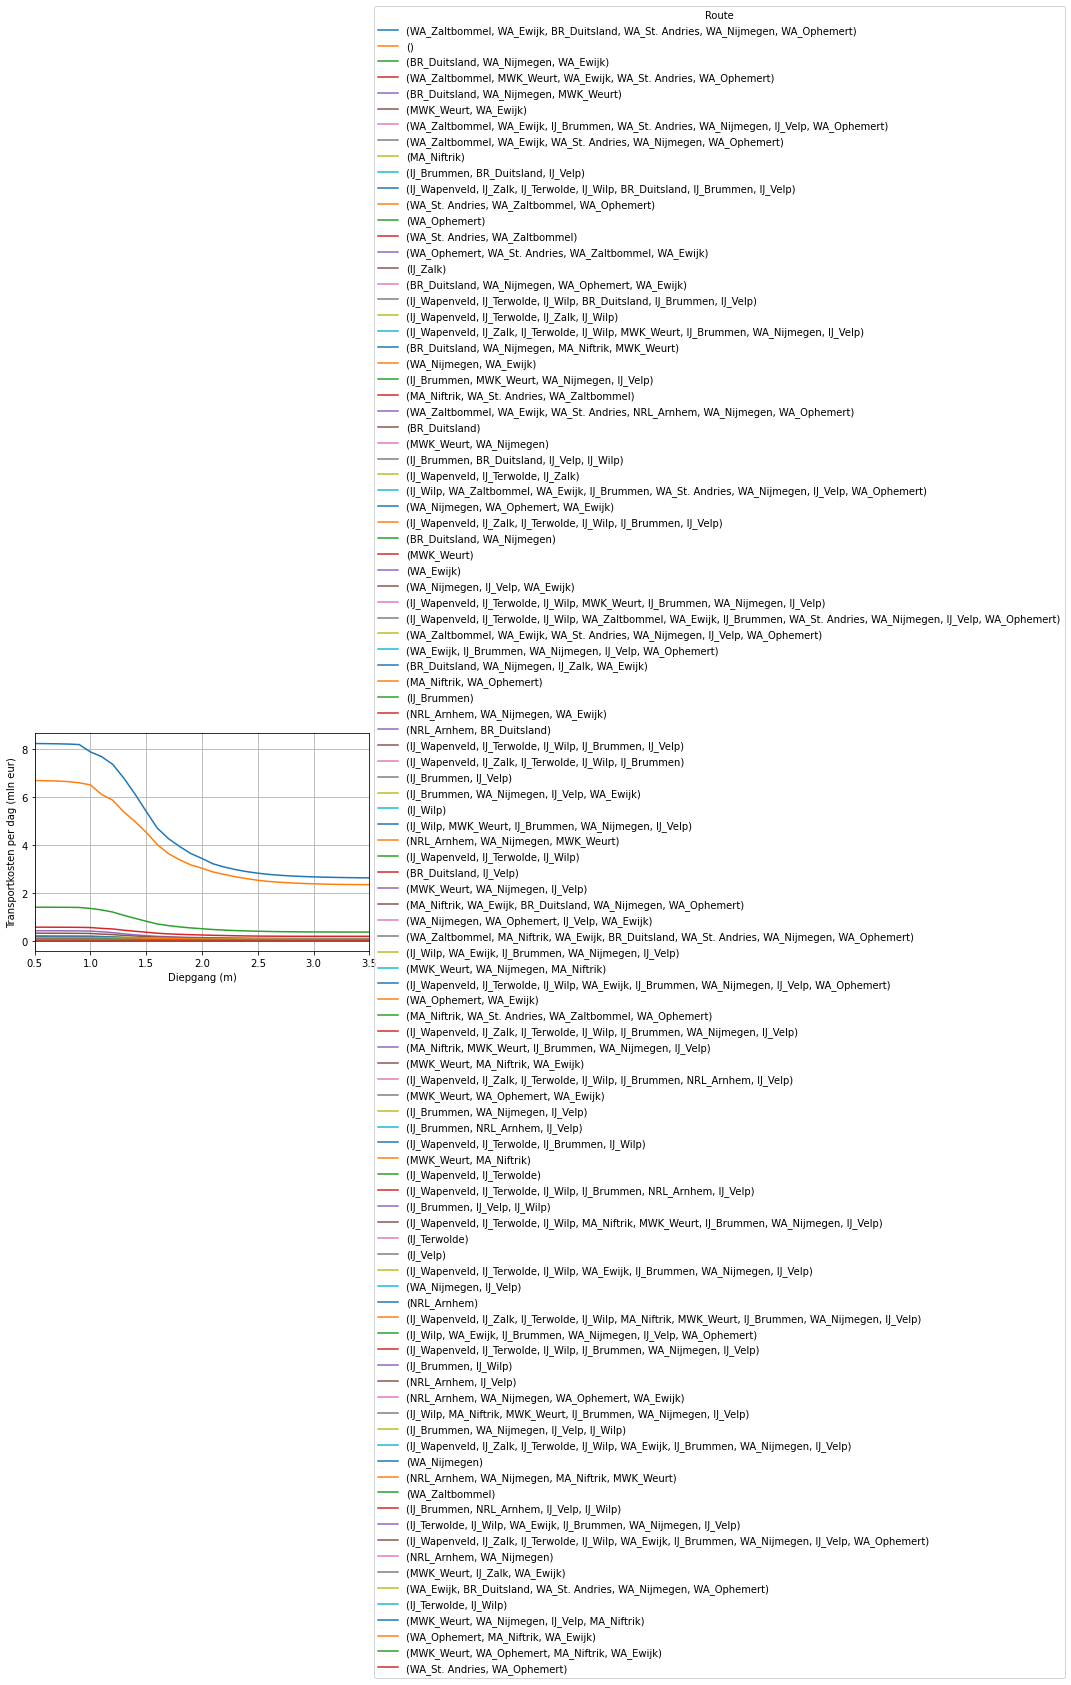

In [17]:
# Plot effect of reducing depth per route
# plotdata = totalcosts.sort_values(10.0, axis=0, ascending=False).loc[:, 1.5:3]
# plotdata = plotdata.sort_index(axis=1, ascending=False).diff(axis=1).fillna(plotdata)

# plotdata.plot.barh(figsize=(10, 4), stacked=True, width=0.8, cmap='Blues', zorder=3)
# plt.gca().invert_yaxis()
# plt.legend(loc='center left', bbox_to_anchor=(1,0.5), title='Beschikbare diepgang (m)')
(totalcosts.sort_values(10.0, axis=0, ascending=False).T / 1e6).plot()
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), title='Route')
plt.ylabel('Transportkosten per dag (mln eur)')
plt.xlabel('Diepgang (m)')
plt.xlim(0.5, 3.5)
plt.grid()

plt.savefig(outputdir / 'route_depth_costs.png', dpi=300, bbox_inches='tight')

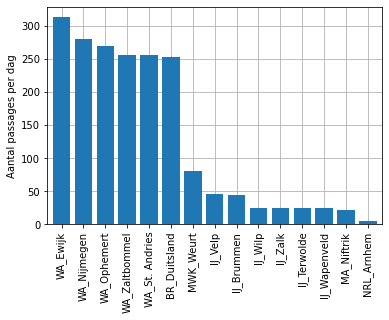

In [175]:
plotdata = (knelpunt_route.sum() / 365).sort_values(ascending=False)
plotdata.plot.bar(width=0.8, zorder=3)
plt.ylabel('Aantal passages per dag')
plt.grid()
plt.savefig(outputdir / 'knelpunten_passages_per_dag.png', dpi=300, bbox_inches='tight')

In [176]:
k = 'IJ_Velp'

routes = effect_and_reaction.loc['trips affected'][0.0]
all_routes = routes.index
all_routes_with_k = [r for r in all_routes if k in r]

all_routes_with_k = routes.loc[all_routes_with_k]
all_routes_with_k = all_routes_with_k[all_routes_with_k > 1]
all_routes_with_k

(IJ_Wapenveld, IJ_Terwolde, IJ_Wilp, IJ_Brummen, IJ_Velp)                                             1.007116
(IJ_Wapenveld, IJ_Zalk, IJ_Terwolde, IJ_Wilp, IJ_Brummen, IJ_Velp)                                    1.336965
(IJ_Brummen, BR_Duitsland, IJ_Velp)                                                                  11.720933
(IJ_Brummen, BR_Duitsland, IJ_Velp, IJ_Wilp)                                                          1.210093
(IJ_Wapenveld, IJ_Terwolde, IJ_Wilp, BR_Duitsland, IJ_Brummen, IJ_Velp)                               2.430425
(IJ_Wapenveld, IJ_Zalk, IJ_Terwolde, IJ_Wilp, BR_Duitsland, IJ_Brummen, IJ_Velp)                      5.770654
(IJ_Brummen, MWK_Weurt, WA_Nijmegen, IJ_Velp)                                                         2.466658
(IJ_Wapenveld, IJ_Zalk, IJ_Terwolde, IJ_Wilp, MWK_Weurt, IJ_Brummen, WA_Nijmegen, IJ_Velp)            2.778797
(WA_Nijmegen, IJ_Velp, WA_Ewijk)                                                                      1.526355
(

## Influence per knelpunt

In [18]:
def reindex_and_interpolate(df, new_index):
    return df.reindex(df.index | new_index).interpolate(method='index', limit_direction='both').loc[new_index]

In [19]:
alltrips_sum = {}
mintrips_sum = {}

# Loop over all knelpunten
for k in tqdm(knelpunt_arcs.keys()):

    # Get all routes which pass the knelpunt
    ii_routes_with_k = [k in totalcosts.index[ii] for ii in range(totalcosts.shape[0])]
    routes_with_k = totalcosts.index[ii_routes_with_k]


    # For each route, compute the number of influenced trip at each depth (both: all trips, and trips where this knelpunt is limiting)
    alltrips = {}
    mintrips = {}

    # For each route
    for r in routes_with_k:

        # Get QH for all knelpunten on route
        r_QH = QH.loc[r].T

        # Convert to relation depth_k-depth_other_k 
        r_HH = r_QH.copy()
        r_HH.index = r_HH.loc[:, k]
        r_HH = r_HH[~r_HH.index.duplicated(keep='first')]  # On duplicate index (=depth) only keep first
        r_HH = reindex_and_interpolate(r_HH, all_depths)  # Reindex to range
        

        # Get index of all depths where k is minimal
        k_minimal = r_HH.idxmin(axis=1) == k

        # Get number of affected trips (per waterdepth)
        alltrips[r] = effect_and_reaction.xs(r, axis=0, level=1)
        mintrips[r] = alltrips[r].loc[:, k_minimal].reindex(all_depths, axis=1).fillna(0)

    alltrips = pd.concat(alltrips, axis=1).T
    mintrips = pd.concat(mintrips, axis=1).T
    
    # Sum over all routes passing given knelpunt, resulting in DataFrame(index=depth, columns=[trips affected, etc.])
    alltrips_sum[k] = alltrips.sum(axis=0, level=1)
    mintrips_sum[k] = mintrips.sum(axis=0, level=1)

alltrips_sum = pd.concat(alltrips_sum, axis=1).swaplevel(axis=1).sort_index(axis=1)
mintrips_sum = pd.concat(mintrips_sum, axis=1).swaplevel(axis=1).sort_index(axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.64it/s]


In [20]:
# Number of trips per route
# effect_and_reaction.loc['trips', 10].sort_values(ascending=False)

# Number of tirps per knelpunt
# alltrips_sum['trips'].loc[10]

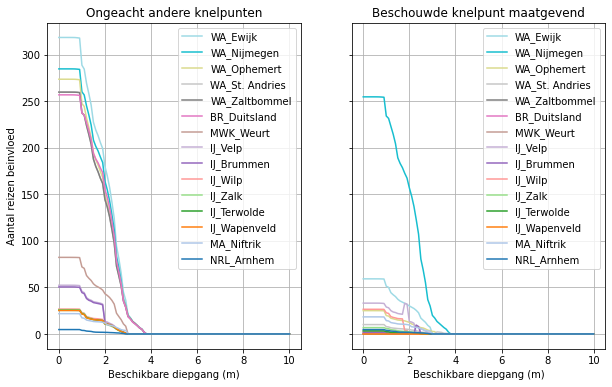

In [21]:
f, ax = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)
plt.sca(ax[0])
plotdata = alltrips_sum.sort_values(axis=1, by=0, ascending=False)['trips affected']
plotdata.plot(cmap='tab20_r', legend=True, ax=ax[0])
plt.grid()
# plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Beschikbare diepgang (m)')
plt.ylabel('Aantal reizen beinvloed')
plt.title('Ongeacht andere knelpunten')

plt.sca(ax[1])
mintrips_sum['trips affected'][plotdata.columns].plot(cmap='tab20_r', ax=ax[1])
plt.grid()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Beschikbare diepgang (m)')
plt.ylabel('Aantal reizen beinvloed')
plt.title('Beschouwde knelpunt maatgevend')
# plt.ylim(top=10000)

plt.savefig(outputdir / 'Effect_knelpunten.png', dpi=300, bbox_inches='tight')

In [22]:
# Validation
# trips['Aantal Vaarbewegingen (-)'].sum() - effect_and_reaction.loc['trips affected'].iloc[0, 0] - mintrips_sum['trips affected'].sum(axis=1).iloc[0]